# Instalando dependências

In [ ]:
!pip install Twython

In [ ]:
!pip install emoji

In [ ]:
!pip install unidecode

In [ ]:
from twython import Twython, TwythonError
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import itertools
import re
import string
import emoji
import unidecode
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Autenticação

In [ ]:
# open the keys file
my_file = open("keys.txt", "r")

# read the raw data
content = my_file.read()

# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split("\n")

# close the file
my_file.close()

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=cZixJgAAAAABTmiYAAABe-batpI


In [ ]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = '7083770'

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

# Coletando tweets

In [ ]:
# Rate limit status
twitter.get_application_rate_limit_status()['resources']['search']

{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1631666618}}

In [ ]:
NUM_TWEETS_TO_FETCH = 18000

cursor = twitter.cursor(twitter.search, q='#setembroamarelo', count=100, result_type='mixed')
search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
len(search_tweets)

12153

In [ ]:
# Search tweets
tweets = []
for tweet in search_tweets:
    tweets.append(tweet['text'])

len(tweets)

12153

In [ ]:
tweets[:10]

['Mais um gol do Nino! Se liga no recado dele sobre a importância do #SetembroAmarelo 🎗️\n\nNão se esqueça. Se precisar… https://t.co/XuHnxsxyIV',
 'NINO 💛 #SetembroAmarelo 🇭🇺\n\n📸: Lucas Merçon/FFC https://t.co/GGx4lWM9MV',
 'É sobre acolher, respeitar e compreender… #SetembroAmarelo #prevencaodosuicidio #CVV188 #acolher https://t.co/p36L8D7sxJ',
 'Se precisar conversar, conte comigo. É só me chamar… #SetembroAmarelo https://t.co/fCTPWgBPYr',
 'RT @flanilopolis: PELA CLASSIFICAÇÃO!!.\nPRA CIMA DELES 🔴⚫\n\n               ⚠️AMANHÃ⚠️\n⚫VENHA TORCER CONOSCO🔴\n\n#SejaSócioFla #VamosFlamengo…',
 'vou fingir que não xinguei meio mundo na priv agora 🌹🌹🌹 #setembroamarelo',
 '*** #setembroamarelo https://t.co/jUCdUI4iT1',
 'RT @Furialvinegra: Neste setembro amarelo, a Fúria Alvinegra se junta luta diária da prevenção ao suicídio.\n\nCaso você ou alguém que conheç…',
 'Hoje na 💛📖terça da leitura📖💛 venho indicar para vocês o livro "A coragem de ser imperfeito", de Brené Brown. A auto… https://t.c

# Análise exploratória dos dados

## Criando um dataframe com informações relevantes

In [ ]:
text = []
retweets = []
favorites = []
followers = []
location = []
name = []
username = []
verified = []

for tweet in search_tweets:
    text.append(tweet["text"])
    retweets.append(tweet["retweet_count"])
    favorites.append(tweet["favorite_count"])
    followers.append(tweet["user"]["followers_count"])
    location.append(tweet["user"]["location"])
    name.append(tweet["user"]["name"])
    username.append(tweet["user"]["screen_name"])
    verified.append(tweet["user"]["verified"])

# create a dataframe using ufrn's followers
df = pd.DataFrame.from_dict({
    "text": text,
    "retweets": retweets,
    "favorites": favorites,
    "followers": followers,
    "location": location,
    "name": name,
    "username": username,
    "verified": verified
})

# check the dataframe
df.head()

,text,retweets,favorites,followers,location,name,username,verified
0,Mais um gol do Nino! Se liga no recado dele so...,96,948,1387040,Rio de Janeiro,Fluminense F.C.,FluminenseFC,True
1,NINO 💛 #SetembroAmarelo 🇭🇺\n\n📸: Lucas Merçon/...,344,2786,1387040,Rio de Janeiro,Fluminense F.C.,FluminenseFC,True
2,"É sobre acolher, respeitar e compreender… #Set...",21,700,18026,Brasil,CVV,CVVoficial,True
3,"Se precisar conversar, conte comigo. É só me c...",0,0,365,Belém-Pa,Amilson Pinheiro,AmilsonPinheiro,False
4,RT @flanilopolis: PELA CLASSIFICAÇÃO!!.\nPRA C...,3,0,1195,"Rio de Janeiro, Brasil",priscila ᶜʳᶠ,priiscrf,False


## Usuários verificados

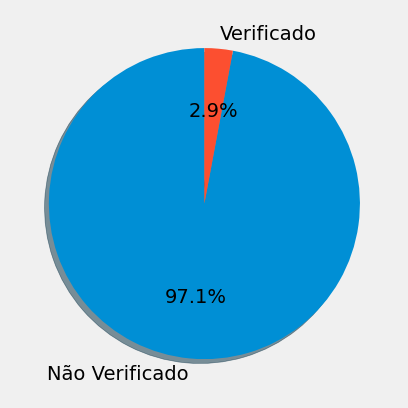

In [ ]:
df.verified.value_counts().plot(kind='pie', shadow = True, startangle=90, autopct='%1.1f%%', labels=["Não Verificado", "Verificado"], ylabel="")

## Localização dos usuários

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


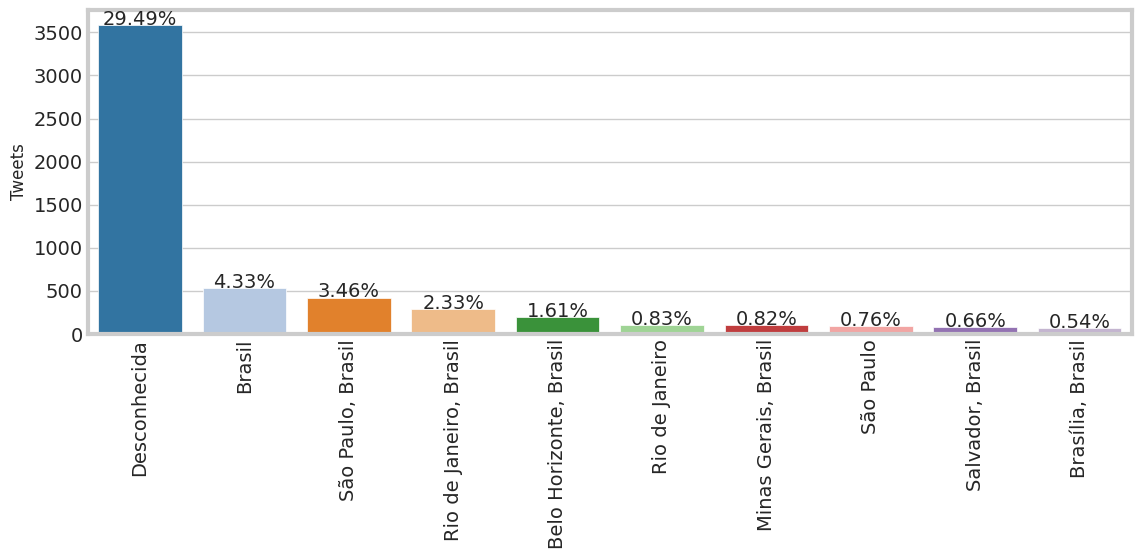

In [ ]:
df["location"] = df["location"].replace("", "Desconhecida")

f, ax = plt.subplots(1,1, figsize=(12,4))
total = float(len(df))
g = sns.countplot(df["location"], order = df["location"].value_counts().index[:10], palette="tab20")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 5,
            '{:1.2f}%'.format(100 * height / total),
            ha="center",
            ) 

plt.ylabel('Tweets', fontsize=12)
plt.xlabel("", fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Limpando os textos

## Removendo URLs

In [ ]:
def remove_url(txt):    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

tweets = [remove_url(tweet) for tweet in tweets]
tweets[:10]

['Mais um gol do Nino! Se liga no recado dele sobre a importância do #SetembroAmarelo 🎗️\n\nNão se esqueça. Se precisar… ',
 'NINO 💛 #SetembroAmarelo 🇭🇺\n\n📸: Lucas Merçon/FFC ',
 'É sobre acolher, respeitar e compreender… #SetembroAmarelo #prevencaodosuicidio #CVV188 #acolher ',
 'Se precisar conversar, conte comigo. É só me chamar… #SetembroAmarelo ',
 'RT @flanilopolis: PELA CLASSIFICAÇÃO!!.\nPRA CIMA DELES 🔴⚫\n\n               ⚠️AMANHÃ⚠️\n⚫VENHA TORCER CONOSCO🔴\n\n#SejaSócioFla #VamosFlamengo…',
 'vou fingir que não xinguei meio mundo na priv agora 🌹🌹🌹 #setembroamarelo',
 '*** #setembroamarelo ',
 'RT @Furialvinegra: Neste setembro amarelo, a Fúria Alvinegra se junta luta diária da prevenção ao suicídio.\n\nCaso você ou alguém que conheç…',
 'Hoje na 💛📖terça da leitura📖💛 venho indicar para vocês o livro "A coragem de ser imperfeito", de Brené Brown. A auto… ',
 '#setembroamarelo ']

## Removendo pontuação

In [ ]:
punctuation = [punc for punc in string.punctuation if punc not in ("#", "@")]
punctuation.append("…")

for punc in punctuation:
    tweets = [tweet.replace(punc, "") for tweet in tweets]

tweets[:10]

['Mais um gol do Nino Se liga no recado dele sobre a importância do #SetembroAmarelo 🎗️\n\nNão se esqueça Se precisar ',
 'NINO 💛 #SetembroAmarelo 🇭🇺\n\n📸 Lucas MerçonFFC ',
 'É sobre acolher respeitar e compreender #SetembroAmarelo #prevencaodosuicidio #CVV188 #acolher ',
 'Se precisar conversar conte comigo É só me chamar #SetembroAmarelo ',
 'RT @flanilopolis PELA CLASSIFICAÇÃO\nPRA CIMA DELES 🔴⚫\n\n               ⚠️AMANHÃ⚠️\n⚫VENHA TORCER CONOSCO🔴\n\n#SejaSócioFla #VamosFlamengo',
 'vou fingir que não xinguei meio mundo na priv agora 🌹🌹🌹 #setembroamarelo',
 ' #setembroamarelo ',
 'RT @Furialvinegra Neste setembro amarelo a Fúria Alvinegra se junta luta diária da prevenção ao suicídio\n\nCaso você ou alguém que conheç',
 'Hoje na 💛📖terça da leitura📖💛 venho indicar para vocês o livro A coragem de ser imperfeito de Brené Brown A auto ',
 '#setembroamarelo ']

## Removendo caracteres especiais

In [ ]:
emojis = list(emoji.UNICODE_EMOJI["en"].keys())

def remove_emoji(text):
    all_chars = list(text)
    emoji_list = [c for c in all_chars if c in emojis]
    clean_text = "".join([char for char in all_chars if char not in emojis])

    return clean_text

tweets = [remove_emoji(tweet) for tweet in tweets]
tweets[:10]

['Mais um gol do Nino Se liga no recado dele sobre a importância do #SetembroAmarelo ️\n\nNão se esqueça Se precisar ',
 'NINO  #SetembroAmarelo 🇭🇺\n\n Lucas MerçonFFC ',
 'É sobre acolher respeitar e compreender #SetembroAmarelo #prevencaodosuicidio #CVV188 #acolher ',
 'Se precisar conversar conte comigo É só me chamar #SetembroAmarelo ',
 'RT @flanilopolis PELA CLASSIFICAÇÃO\nPRA CIMA DELES \n\n               ️AMANHÃ️\nVENHA TORCER CONOSCO\n\n#SejaSócioFla #VamosFlamengo',
 'vou fingir que não xinguei meio mundo na priv agora  #setembroamarelo',
 ' #setembroamarelo ',
 'RT @Furialvinegra Neste setembro amarelo a Fúria Alvinegra se junta luta diária da prevenção ao suicídio\n\nCaso você ou alguém que conheç',
 'Hoje na terça da leitura venho indicar para vocês o livro A coragem de ser imperfeito de Brené Brown A auto ',
 '#setembroamarelo ']

In [ ]:
tweets = [tweet.replace("\n", " ") for tweet in tweets]
tweets[:10]

['Mais um gol do Nino Se liga no recado dele sobre a importância do #SetembroAmarelo ️  Não se esqueça Se precisar ',
 'NINO  #SetembroAmarelo 🇭🇺   Lucas MerçonFFC ',
 'É sobre acolher respeitar e compreender #SetembroAmarelo #prevencaodosuicidio #CVV188 #acolher ',
 'Se precisar conversar conte comigo É só me chamar #SetembroAmarelo ',
 'RT @flanilopolis PELA CLASSIFICAÇÃO PRA CIMA DELES                  ️AMANHÃ️ VENHA TORCER CONOSCO  #SejaSócioFla #VamosFlamengo',
 'vou fingir que não xinguei meio mundo na priv agora  #setembroamarelo',
 ' #setembroamarelo ',
 'RT @Furialvinegra Neste setembro amarelo a Fúria Alvinegra se junta luta diária da prevenção ao suicídio  Caso você ou alguém que conheç',
 'Hoje na terça da leitura venho indicar para vocês o livro A coragem de ser imperfeito de Brené Brown A auto ',
 '#setembroamarelo ']

## Quebrando tweets em listas de palavras

In [ ]:
tweets_lists = [tweet.split() for tweet in tweets]
print(tweets_lists[:5])

[['Mais', 'um', 'gol', 'do', 'Nino', 'Se', 'liga', 'no', 'recado', 'dele', 'sobre', 'a', 'importância', 'do', '#SetembroAmarelo', '️', 'Não', 'se', 'esqueça', 'Se', 'precisar'], ['NINO', '#SetembroAmarelo', '🇭🇺', 'Lucas', 'MerçonFFC'], ['É', 'sobre', 'acolher', 'respeitar', 'e', 'compreender', '#SetembroAmarelo', '#prevencaodosuicidio', '#CVV188', '#acolher'], ['Se', 'precisar', 'conversar', 'conte', 'comigo', 'É', 'só', 'me', 'chamar', '#SetembroAmarelo'], ['RT', '@flanilopolis', 'PELA', 'CLASSIFICAÇÃO', 'PRA', 'CIMA', 'DELES', '️AMANHÃ️', 'VENHA', 'TORCER', 'CONOSCO', '#SejaSócioFla', '#VamosFlamengo']]


## Removendo números

In [ ]:
tweets_lists = [[word for word in tweet if not word.isnumeric()] for tweet in tweets_lists]
print(tweets_lists[:5])

[['Mais', 'um', 'gol', 'do', 'Nino', 'Se', 'liga', 'no', 'recado', 'dele', 'sobre', 'a', 'importância', 'do', '#SetembroAmarelo', '️', 'Não', 'se', 'esqueça', 'Se', 'precisar'], ['NINO', '#SetembroAmarelo', '🇭🇺', 'Lucas', 'MerçonFFC'], ['É', 'sobre', 'acolher', 'respeitar', 'e', 'compreender', '#SetembroAmarelo', '#prevencaodosuicidio', '#CVV188', '#acolher'], ['Se', 'precisar', 'conversar', 'conte', 'comigo', 'É', 'só', 'me', 'chamar', '#SetembroAmarelo'], ['RT', '@flanilopolis', 'PELA', 'CLASSIFICAÇÃO', 'PRA', 'CIMA', 'DELES', '️AMANHÃ️', 'VENHA', 'TORCER', 'CONOSCO', '#SejaSócioFla', '#VamosFlamengo']]


## Deixando tudo em letras minúsculas

In [ ]:
tweets_lists = [[word.lower() for word in tweet] for tweet in tweets_lists]
print(tweets_lists[:5])

[['mais', 'um', 'gol', 'do', 'nino', 'se', 'liga', 'no', 'recado', 'dele', 'sobre', 'a', 'importância', 'do', '#setembroamarelo', '️', 'não', 'se', 'esqueça', 'se', 'precisar'], ['nino', '#setembroamarelo', '🇭🇺', 'lucas', 'merçonffc'], ['é', 'sobre', 'acolher', 'respeitar', 'e', 'compreender', '#setembroamarelo', '#prevencaodosuicidio', '#cvv188', '#acolher'], ['se', 'precisar', 'conversar', 'conte', 'comigo', 'é', 'só', 'me', 'chamar', '#setembroamarelo'], ['rt', '@flanilopolis', 'pela', 'classificação', 'pra', 'cima', 'deles', '️amanhã️', 'venha', 'torcer', 'conosco', '#sejasóciofla', '#vamosflamengo']]


## Removendo stopwords

In [ ]:
stopwords = []

my_file = open("/content/stopwords-pt.txt", "r")

content = my_file.read()

stopwords = content.split("\n")
my_file.close()

stopwords.extend(['vc', 'vcs', 'pra', 'pro', 'ta', 'to', 'p', 'q', 'd', 'r', 'f'])
len(stopwords)

571

In [ ]:
tweets_lists = [[word.lower() for word in tweet if word not in stopwords] for tweet in tweets_lists]
print(tweets_lists[:5])

[['gol', 'nino', 'liga', 'recado', 'importância', '#setembroamarelo', '️', 'esqueça', 'precisar'], ['nino', '#setembroamarelo', '🇭🇺', 'lucas', 'merçonffc'], ['acolher', 'respeitar', 'compreender', '#setembroamarelo', '#prevencaodosuicidio', '#cvv188', '#acolher'], ['precisar', 'conversar', 'conte', 'comigo', 'chamar', '#setembroamarelo'], ['rt', '@flanilopolis', 'classificação', '️amanhã️', 'venha', 'torcer', 'conosco', '#sejasóciofla', '#vamosflamengo']]


## Removendo marcações

In [ ]:
tweets_lists = [[word for word in tweet if not word.startswith("@")] for tweet in tweets_lists]
print(tweets_lists[:5])

[['gol', 'nino', 'liga', 'recado', 'importância', '#setembroamarelo', '️', 'esqueça', 'precisar'], ['nino', '#setembroamarelo', '🇭🇺', 'lucas', 'merçonffc'], ['acolher', 'respeitar', 'compreender', '#setembroamarelo', '#prevencaodosuicidio', '#cvv188', '#acolher'], ['precisar', 'conversar', 'conte', 'comigo', 'chamar', '#setembroamarelo'], ['rt', 'classificação', '️amanhã️', 'venha', 'torcer', 'conosco', '#sejasóciofla', '#vamosflamengo']]


## Removendo acentos

In [ ]:
def remove_accents(text):
    try:
        e = unidecode.unidecode_expect_ascii(text)
        return unidecode.unidecode(e)
    except:
        return text

tweets_lists = [[remove_accents(word) for word in tweet] for tweet in tweets_lists]
print(tweets_lists[:5])

[['gol', 'nino', 'liga', 'recado', 'importancia', '#setembroamarelo', '', 'esqueca', 'precisar'], ['nino', '#setembroamarelo', '', 'lucas', 'merconffc'], ['acolher', 'respeitar', 'compreender', '#setembroamarelo', '#prevencaodosuicidio', '#cvv188', '#acolher'], ['precisar', 'conversar', 'conte', 'comigo', 'chamar', '#setembroamarelo'], ['rt', 'classificacao', 'amanha', 'venha', 'torcer', 'conosco', '#sejasociofla', '#vamosflamengo']]


## Removendo "rt"

In [ ]:
tweets_lists = [[word for word in tweet if word != "rt"] for tweet in tweets_lists]
print(tweets_lists[:5])

[['gol', 'nino', 'liga', 'recado', 'importancia', '#setembroamarelo', '', 'esqueca', 'precisar'], ['nino', '#setembroamarelo', '', 'lucas', 'merconffc'], ['acolher', 'respeitar', 'compreender', '#setembroamarelo', '#prevencaodosuicidio', '#cvv188', '#acolher'], ['precisar', 'conversar', 'conte', 'comigo', 'chamar', '#setembroamarelo'], ['classificacao', 'amanha', 'venha', 'torcer', 'conosco', '#sejasociofla', '#vamosflamengo']]


##Removendo palavras de apenas uma letra

In [ ]:
tweets_lists = [[word for word in tweet if len(word) > 1] for tweet in tweets_lists]
print(tweets_lists[:5])

[['gol', 'nino', 'liga', 'recado', 'importancia', '#setembroamarelo', 'esqueca', 'precisar'], ['nino', '#setembroamarelo', 'lucas', 'merconffc'], ['acolher', 'respeitar', 'compreender', '#setembroamarelo', '#prevencaodosuicidio', '#cvv188', '#acolher'], ['precisar', 'conversar', 'conte', 'comigo', 'chamar', '#setembroamarelo'], ['classificacao', 'amanha', 'venha', 'torcer', 'conosco', '#sejasociofla', '#vamosflamengo']]


## Removendo repetições de palavras

In [ ]:
tweets_sets = [set(tweet) for tweet in tweets_lists]
print(tweets_sets[:5])

[{'#setembroamarelo', 'esqueca', 'gol', 'nino', 'importancia', 'liga', 'precisar', 'recado'}, {'#setembroamarelo', 'lucas', 'merconffc', 'nino'}, {'respeitar', '#setembroamarelo', '#acolher', 'compreender', '#cvv188', '#prevencaodosuicidio', 'acolher'}, {'conversar', '#setembroamarelo', 'chamar', 'precisar', 'comigo', 'conte'}, {'amanha', 'conosco', 'venha', '#sejasociofla', 'torcer', '#vamosflamengo', 'classificacao'}]


# Recortando dados

## Contando ocorrências de cada palavra

In [ ]:
word_count = {}

for tweet in tweets_sets:
    for word in tweet:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

word_count["#setembroamarelo"]

6798

## Obtendo palavras acima do 3º quintil

In [ ]:
counter = Counter(word_count)
relevant_words = {tup[0]: tup[1] for tup in counter.most_common(int(len(word_count) * 0.4))}

relevant_words["#setembroamarelo"]

6798

## Filtrando palavras relevantes nos tweets

In [ ]:
tweets_words = [[word for word in tweet if word in relevant_words] for tweet in tweets_sets]
print(tweets_words[:5])

[['#setembroamarelo', 'esqueca', 'nino', 'importancia', 'liga', 'precisar', 'recado'], ['#setembroamarelo', 'lucas', 'nino'], ['respeitar', '#setembroamarelo', '#acolher', 'compreender', '#cvv188', '#prevencaodosuicidio', 'acolher'], ['conversar', '#setembroamarelo', 'chamar', 'precisar', 'comigo', 'conte'], ['amanha', 'conosco', 'venha']]


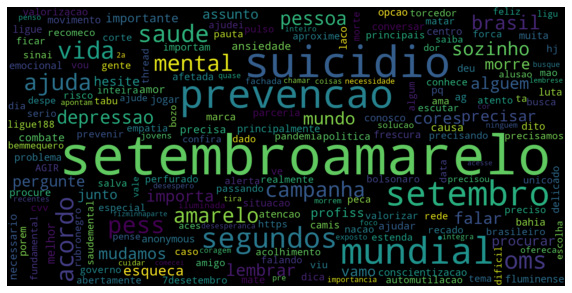

In [ ]:
all_words = [word for list_words in tweets_words for word in list_words]
words = " ".join(w for w in all_words)

wordcloud = WordCloud(background_color="black", 
                      collocations = False,
                      width=1600, height=800).generate(words)
 
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
 
plt.show();

# Criando a rede de palavras

## Obtendo pares de palavras por tweet

In [ ]:
tweets_pairs = [list(itertools.combinations(tweet, 2)) for tweet in tweets_words]
print(tweets_pairs[:5])

[[('#setembroamarelo', 'esqueca'), ('#setembroamarelo', 'nino'), ('#setembroamarelo', 'importancia'), ('#setembroamarelo', 'liga'), ('#setembroamarelo', 'precisar'), ('#setembroamarelo', 'recado'), ('esqueca', 'nino'), ('esqueca', 'importancia'), ('esqueca', 'liga'), ('esqueca', 'precisar'), ('esqueca', 'recado'), ('nino', 'importancia'), ('nino', 'liga'), ('nino', 'precisar'), ('nino', 'recado'), ('importancia', 'liga'), ('importancia', 'precisar'), ('importancia', 'recado'), ('liga', 'precisar'), ('liga', 'recado'), ('precisar', 'recado')], [('#setembroamarelo', 'lucas'), ('#setembroamarelo', 'nino'), ('lucas', 'nino')], [('respeitar', '#setembroamarelo'), ('respeitar', '#acolher'), ('respeitar', 'compreender'), ('respeitar', '#cvv188'), ('respeitar', '#prevencaodosuicidio'), ('respeitar', 'acolher'), ('#setembroamarelo', '#acolher'), ('#setembroamarelo', 'compreender'), ('#setembroamarelo', '#cvv188'), ('#setembroamarelo', '#prevencaodosuicidio'), ('#setembroamarelo', 'acolher'), ('

## Criando o grafo

In [ ]:
G = nx.Graph()
G.add_nodes_from(relevant_words.keys())

for key, props in G.nodes.items():
    props["count"] = relevant_words[key]

for pairs in tweets_pairs:
    for pair in pairs:
        if G.has_edge(*pair):
            G.edges[pair]["weight"] += 1
        else:
            G.add_edge(*pair, weight=1)

print(f"{len(G)} nodes, {nx.number_of_edges(G)} edges")

3311 nodes, 42915 edges


## Exportando rede

In [ ]:
nx.write_graphml(G, "setembro_amarelo2.graphml")

# Métricas da rede

## Removendo nó \#setembroamarelo

In [ ]:
G.remove_node("#setembroamarelo")

## Identificando nós com maior degree centrality

In [ ]:
degree_centrality = nx.degree_centrality(G)
sorted_dc = {k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)}

i = 0
for key, value in sorted_dc.items():
    if i == 10:
        break

    print(f"{i + 1}. {key} ({value})")
    i += 1

1. suicidio (0.3275914173466304)
2. setembro (0.28558476881233)
3. prevencao (0.25173768510123906)
4. vida (0.22725899063161076)
5. amarelo (0.21214868540344514)
6. saude (0.20187367784829252)
7. mental (0.17467512843759445)
8. mundial (0.17104865518283469)
9. depressao (0.15956482320942883)
10. campanha (0.1489876095497129)


## Desenhando core da rede com degree centrality

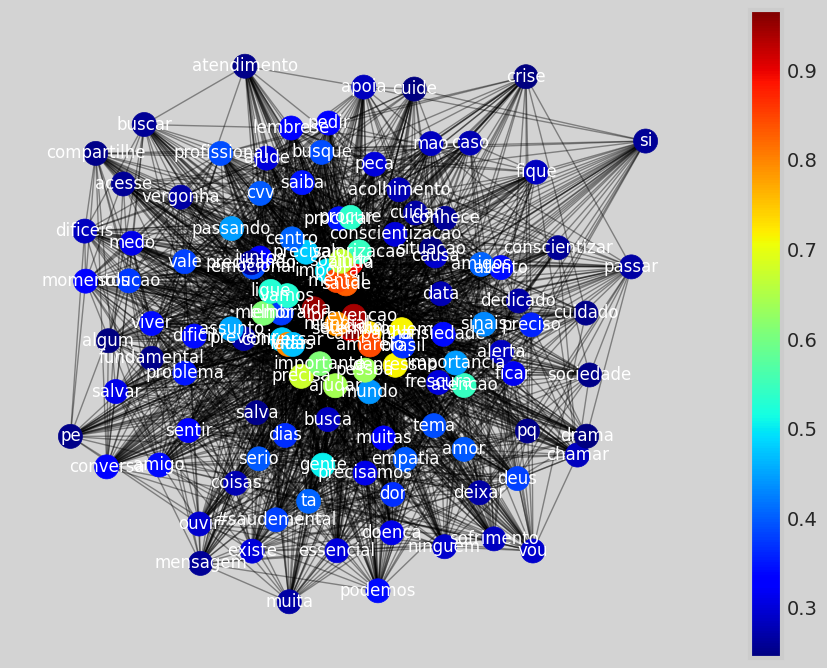

In [ ]:
core = nx.k_core(G, 30)

# the degree centrality of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# layout position
pos = nx.spring_layout(core,seed=123456789)
# color of nodes
color = list(dict(nx.degree_centrality(core)).values())

# draw edges
nx.draw_networkx_edges(core,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(core,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax)

# draw labels
nx.draw_networkx_labels(core, pos=pos,
                        font_color='white', ax=ax)

fig.set_facecolor("lightgray")
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree_centrality.png', transparent=True,dpi=300)
plt.show()

## Comparando métricas de centralidade da rede

In [ ]:
bc = pd.Series(nx.betweenness_centrality(g))
dc = pd.Series(nx.degree_centrality(g))
ec = pd.Series(nx.eigenvector_centrality(g))
cc = pd.Series(nx.closeness_centrality(g))

df = pd.DataFrame.from_dict({"Betweenness": bc,
                            "Degree": dc,
                            "EigenVector": ec,
                            "Closeness": cc})
df.reset_index(inplace=True,drop=True)
df.head()

,Betweenness,Degree,EigenVector,Closeness
0,0.001883,0.317073,0.067729,0.594203
1,0.000639,0.252033,0.060589,0.572093
2,0.001221,0.284553,0.064573,0.582938
3,0.003837,0.390244,0.078351,0.621212
4,0.002797,0.390244,0.083748,0.621212


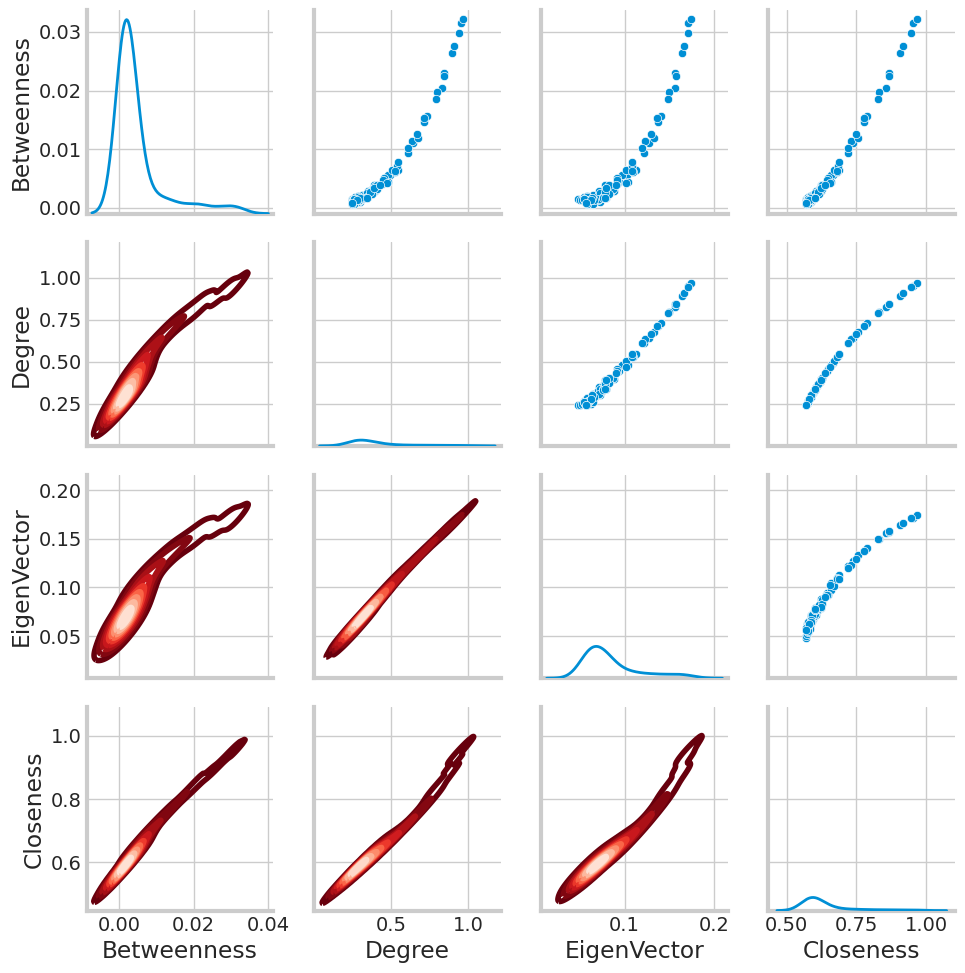

In [ ]:
fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
plt.show()